In [4]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
import utils

features = utils.load('fma_metadata/data/fma_metadata/features.csv') 
genres = utils.load('fma_metadata/data/fma_metadata/genres.csv')
tracks = utils.load('fma_metadata/data/fma_metadata/tracks.csv')
echonest = utils.load('fma_metadata/data/fma_metadata/echonest.csv')

print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

features.head()

16 top-level genres


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

(106574,) (106574,) (106574,)
(2000, 140)
(2000,)


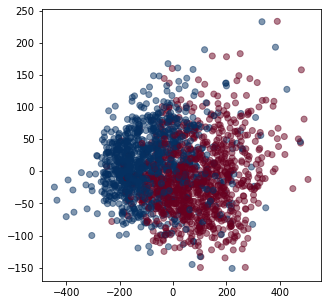

((2000, 2), (2000,))

In [10]:
#One Hot Encoding Rock Genre

from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import MinMaxScaler as minmax
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Folk'

print(small.shape, genre1.shape, genre2.shape)

X = features.loc[small & (genre1 | genre2), 'mfcc']
# X = features.loc[small & (genre1 | genre2), 'mfcc':'spectral_contrast']
print(X.shape)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
print(y.shape)

oh = pd.get_dummies(y, prefix='genre')
oh.head()

X = skl.decomposition.PCA(n_components=2).fit_transform(X)
#X = minmax.fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

fig = plt.figure( figsize= (5,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
plt.show()
X.shape, y.shape

In [15]:
features.columns.levels[0]

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

In [32]:


compressed_features = pd.DataFrame(skl.decomposition.PCA(n_components=1).fit_transform(features.loc[small , 'mfcc']))

for x in features.columns.levels[0]:
        compressed_features[x] = skl.decomposition.PCA(n_components=1).fit_transform(features.loc[small , x])
# for x in features.columns.levels[0]:
#         print(x)
compressed_features.drop(0, axis=1, inplace=True)
compressed_features.head()

_ = compressed_features.hist(figsize=(16,16), grid=False)

,chroma_cens,chroma_cqt,chroma_stft,mfcc,rmse,spectral_bandwidth,spectral_centroid,spectral_contrast,spectral_rolloff,tonnetz,zcr
0,1.087264,-0.841954,-0.565135,-93.924253,1.074865,244.719264,62.757234,-14.392589,1327.632996,1.449442,-25.852672
1,-0.377099,-0.579964,-0.578177,-5.467157,-1.348527,168.639642,14.593599,-12.422014,801.141162,7.713286,-24.800177
2,3.091406,0.026566,1.312020,-111.985279,0.322551,-51.656158,-82.649364,-8.358257,125.505390,0.809858,-10.135438
3,-1.556062,-1.392952,0.111283,13.106209,-1.353019,94.065054,930.001559,-0.129345,103.552543,-0.158172,-20.524756
4,-1.761146,-0.852443,2.124934,78.081377,-0.553165,-338.432200,272.111857,6.896948,-689.388222,-0.803023,1.441258


In [26]:
# Pearson correlation by default in pandas
corr = compressed_features.corr()
# This is an example using pandas built-in visualization
# Determine the background colors with data in each cell
corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)

C:\Users\shuba\AppData\Local\Temp/ipykernel_5380/697526894.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)


,chroma_cens,chroma_cqt,chroma_stft,mfcc,rmse,spectral_bandwidth,spectral_centroid,spectral_contrast,spectral_rolloff,tonnetz,zcr
chroma_cens,1.000,0.075,0.003,0.015,0.009,-0.016,0.037,0.026,-0.006,0.033,-0.005
chroma_cqt,0.075,1.000,0.006,0.021,-0.001,-0.008,0.009,0.011,-0.017,-0.008,0.019
chroma_stft,0.003,0.006,1.000,0.016,0.000,-0.021,0.030,0.022,-0.012,-0.005,0.010
mfcc,0.015,0.021,0.016,1.000,0.121,-0.497,0.139,0.684,-0.535,-0.069,0.194
rmse,0.009,-0.001,0.000,0.121,1.000,0.020,0.049,0.030,0.019,0.010,-0.011
spectral_bandwidth,-0.016,-0.008,-0.021,-0.497,0.020,1.000,-0.310,-0.643,0.926,0.059,-0.226
spectral_centroid,0.037,0.009,0.030,0.139,0.049,-0.310,1.000,0.117,-0.292,-0.060,-0.219
spectral_contrast,0.026,0.011,0.022,0.684,0.030,-0.643,0.117,1.000,-0.619,-0.053,0.199
spectral_rolloff,-0.006,-0.017,-0.012,-0.535,0.019,0.926,-0.292,-0.619,1.000,0.086,-0.265
tonnetz,0.033,-0.008,-0.005,-0.069,0.010,0.059,-0.060,-0.053,0.086,1.000,-0.059


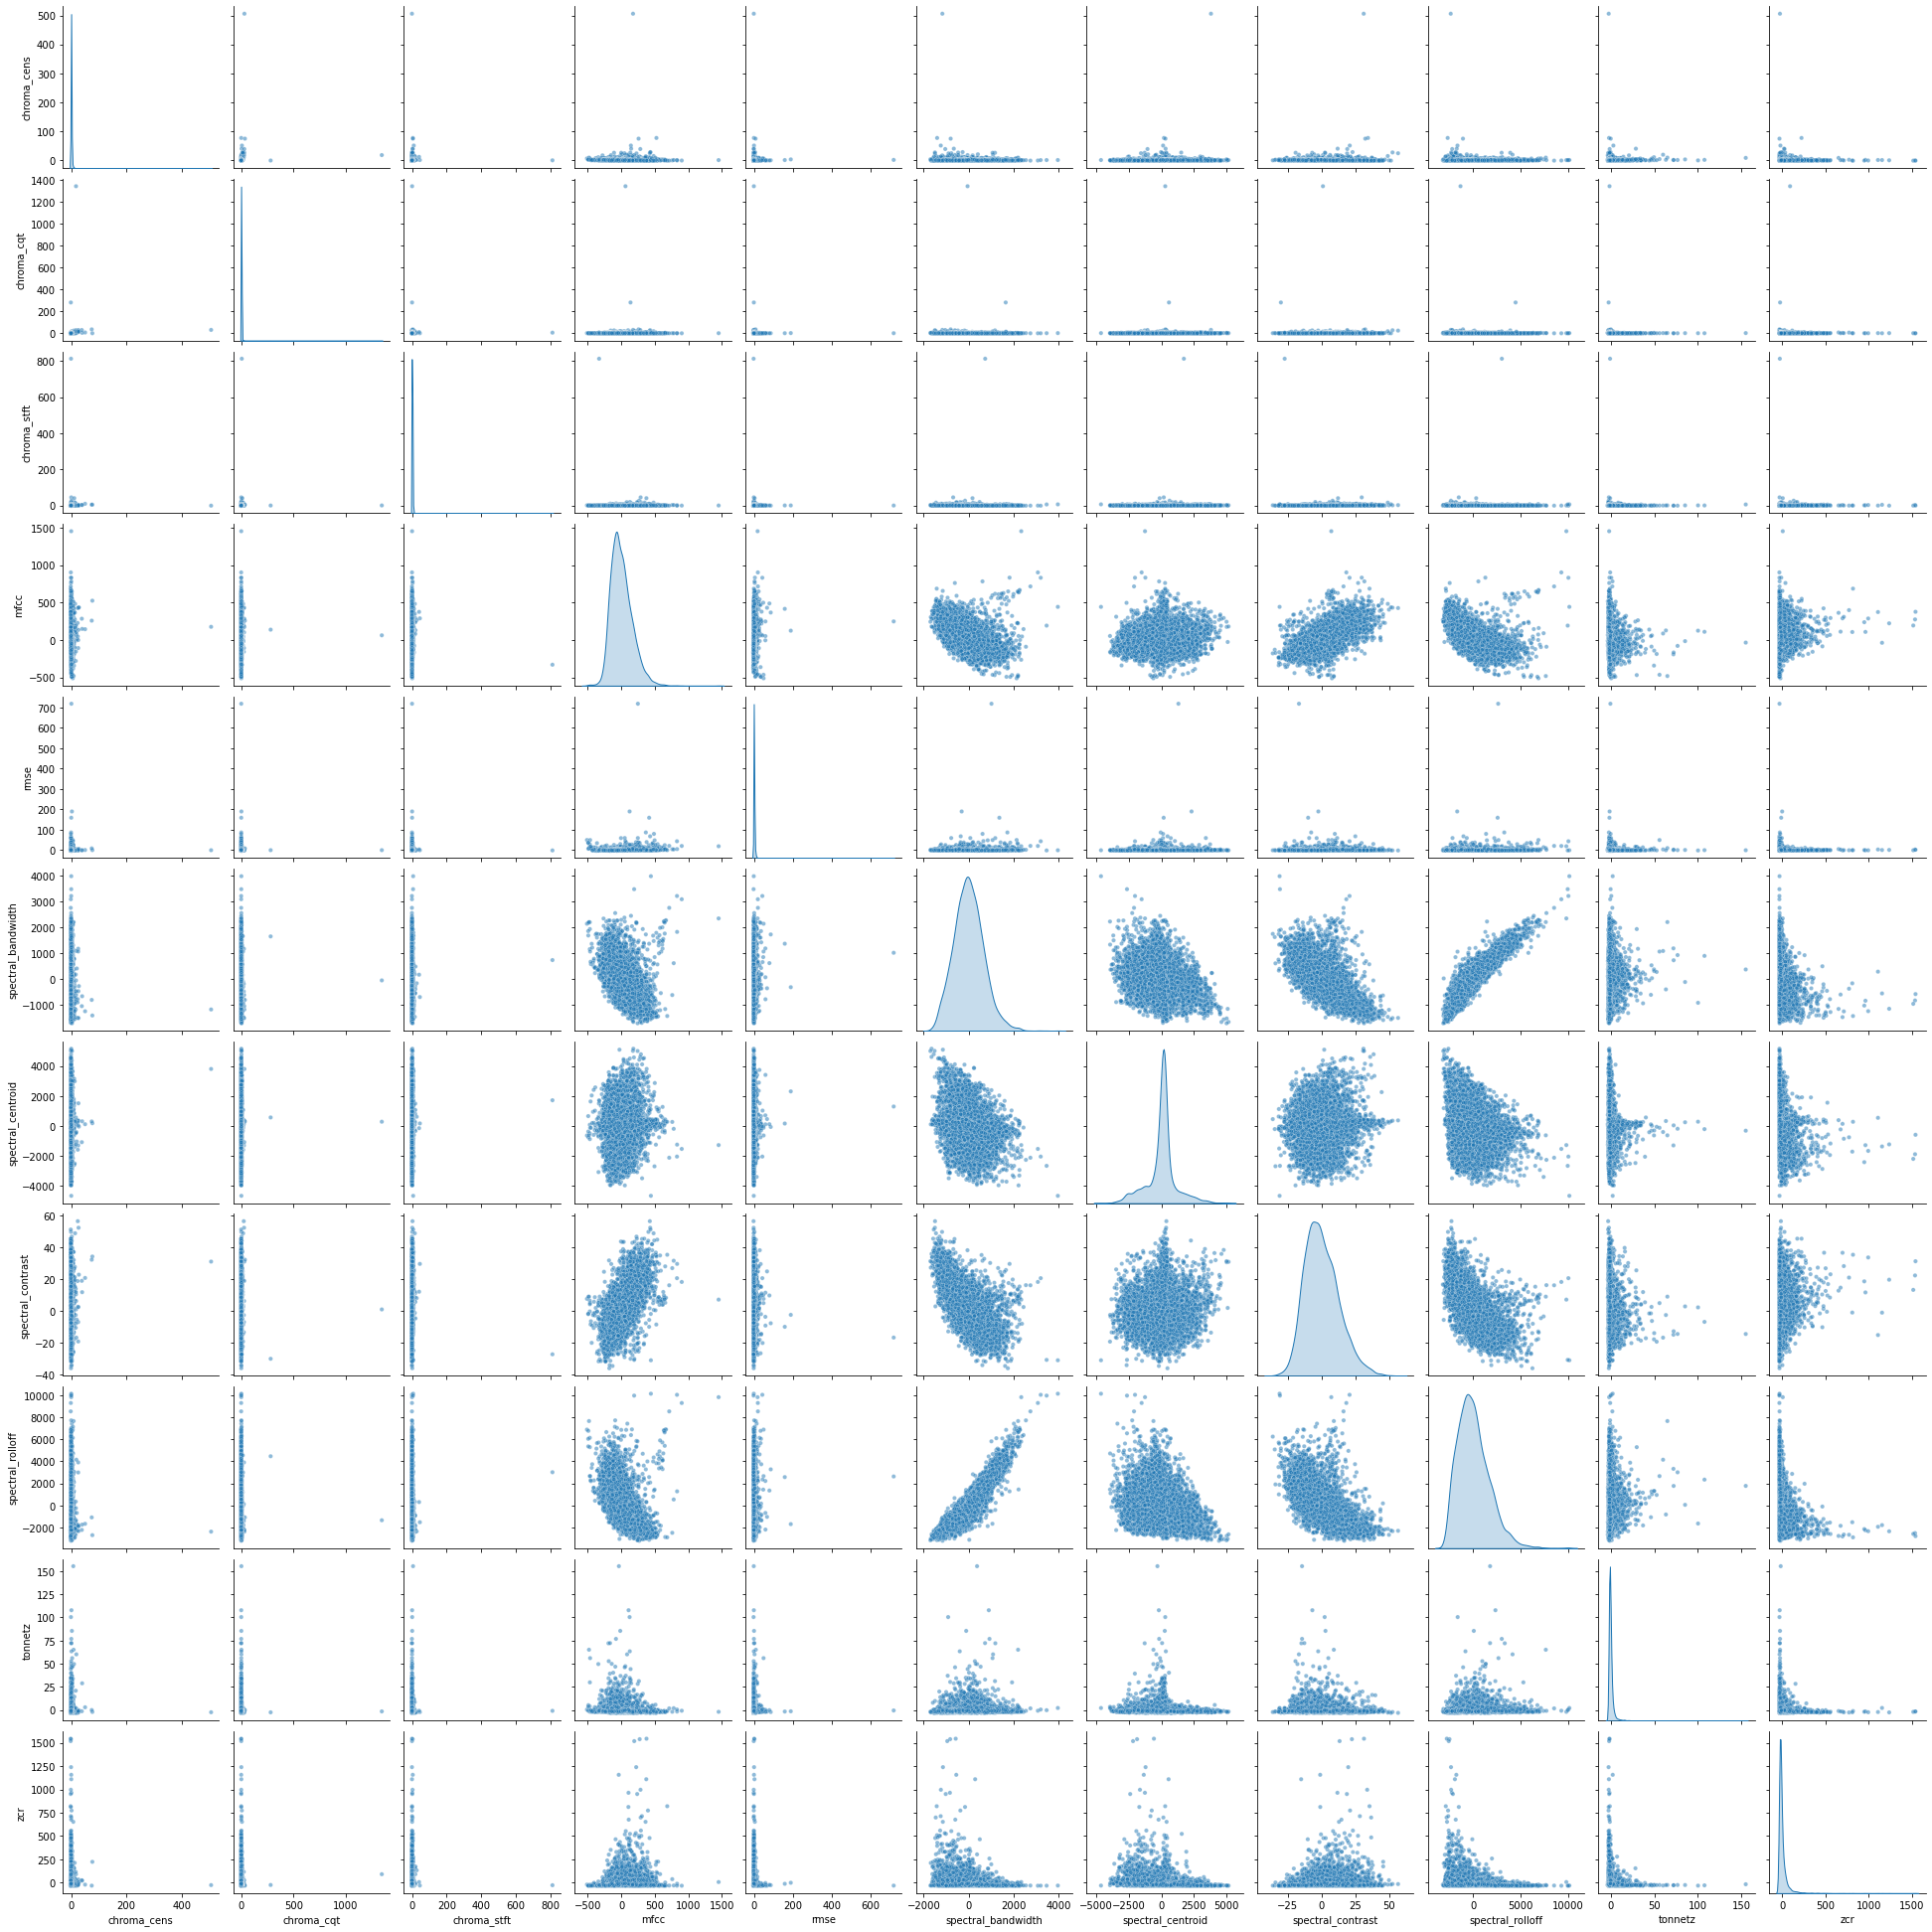

In [28]:
import seaborn as sns

sns.pairplot(data=compressed_features,
             # Variables within data to use
             vars=features.columns.levels[0],
             # Use kde for the diagonal subplots
             diag_kind='kde',
             plot_kws=dict(
                 size=.5,
                 alpha=.5,
             ))

(106574,) (106574,) (106574,)
(2000, 84)
(2000,)


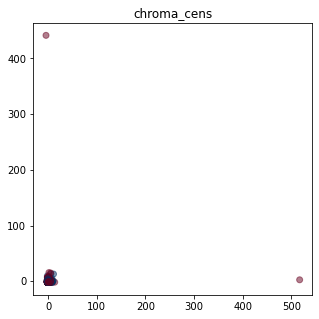

(2000, 84)
(2000,)


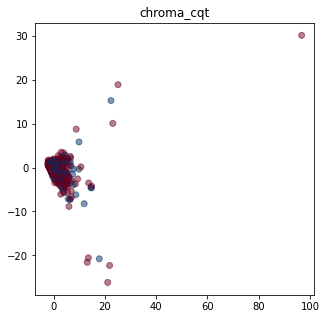

(2000, 84)
(2000,)


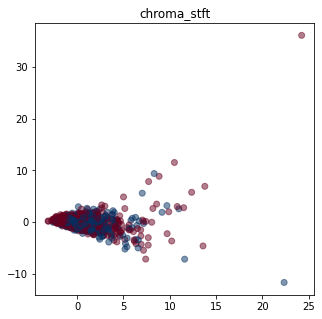

(2000, 140)
(2000,)


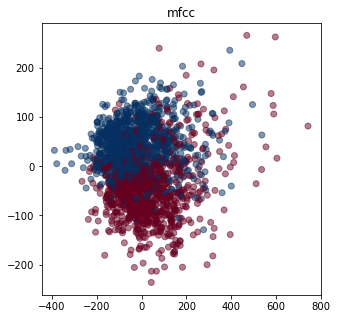

(2000, 7)
(2000,)


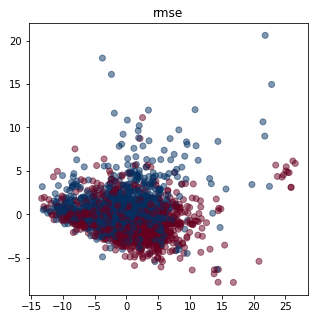

(2000, 7)
(2000,)


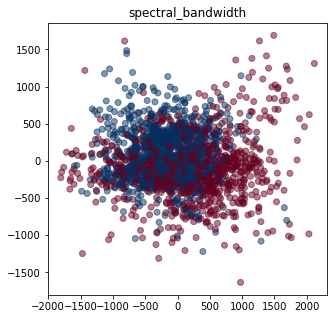

(2000, 7)
(2000,)


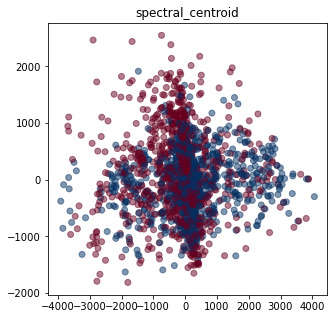

(2000, 49)
(2000,)


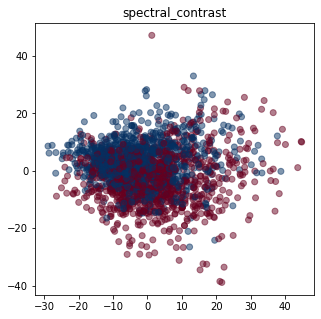

(2000, 7)
(2000,)


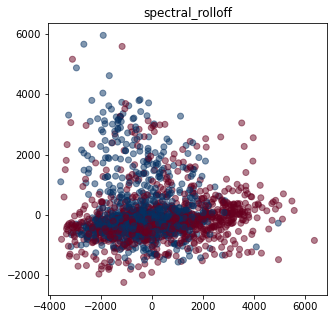

(2000, 42)
(2000,)


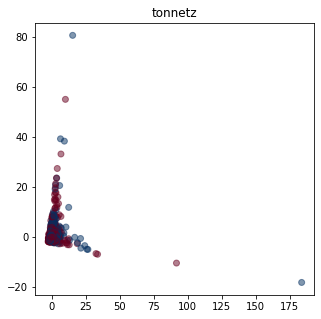

(2000, 7)
(2000,)


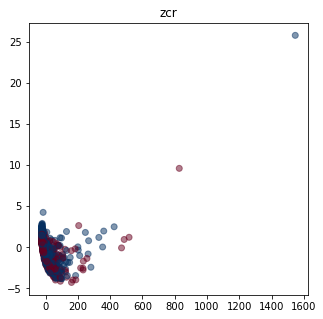

In [31]:
#One Hot Encoding Rock Genre

from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import MinMaxScaler as minmax
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Electronic'

print(small.shape, genre1.shape, genre2.shape)
for col in features.columns.levels[0]:
        X = features.loc[small & (genre1 | genre2), col]
        # X = features.loc[small & (genre1 | genre2), 'mfcc':'spectral_contrast']
        print(X.shape)

        y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
        print(y.shape)

        oh = pd.get_dummies(y, prefix='genre')
        oh.head()

        X = skl.decomposition.PCA(n_components=2).fit_transform(X)
        #X = minmax.fit_transform(X)

        y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
        y = skl.preprocessing.LabelEncoder().fit_transform(y)

        fig = plt.figure( figsize= (5,5))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
        plt.title(col)
        plt.show()
        X.shape, y.shape